# Landsat-8 LST Retrieval Time Series via Sentinel-Hub Process API

### _Import functional dependencies and add repository source directory to system path_

In [1]:
import os
import yaml
from munch import munchify

In [2]:
# define repo name and get root working directory
repo = 'sentinelhub-py'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\Chris.Williams\\Documents\\GitHub\\sentinelhub-py'

In [3]:
# add repo source + notebooks directory to system path
import sys
sys.path.insert(0, os.path.join( root_path, 'src' ) )
sys.path.insert(0, os.path.join( root_path, 'notebooks' ) )

In [4]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'landsat-8' )
cfg_path

'C:\\Users\\Chris.Williams\\Documents\\GitHub\\sentinelhub-py\\cfg\\landsat-8'

### _Load configuration file from repository cfg sub-directory_ 

In [5]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 'l8-timeseries-lst.yml' )

In [6]:
# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    collection: LANDSAT8
    evalscript: |
                //VERSION=3 (auto-converted from 1)
                //// STARTING OPTIONS
                // choose on basis of which band (B10 or B11) LST mapping will be done
                var band="B10";
                // minimum and maximum values for output colour chart red to white for temperature in ï¿½C. Option 2 overwrites this selection!
                var minC = 0;
                var maxC = 50;
                ////INPUT DATA - FOR BETTER RESULTS, THE DATA SHOULD BE ADJUSTED
                // NVDIs for bare soil and NDVIv for full vegetation
                // Note: NVDIs for bare soil and NDVIv for full vegetation are needed to be evaluated for every scene. However in the custom script, default values are set regarding:
                // http://profhorn.meteor.wisc.edu/wxwise/satmet/lesson3/ndvi.html 
                // https://www.researchgate.net/post/Can_anyone_help_me_to_define_a_range_of_NDVI_value_to_extract_ba

In [7]:
# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

### _Define area of interest centred on the Wadi Rum Desert, Jordan_

In [8]:
# define min and max latlons
coords = 34.928284,29.286098,35.656128,29.847126
resolution = 30

In [9]:
# create instance of shclient class
from client import ShClient
client = ShClient( config )

In [10]:
# get utm bbox
bbox = client.getBoundingBox( coords )
print ( bbox, bbox.crs.value )

687313.7877611384,3241225.7434842116,756615.8514537602,3304807.5203539804 32636


In [11]:
# get aoi image dimensions
client.getBoxDimensions( bbox, resolution )

(2310, 2119)

### _Use Catalog API to locate available L8 scenes acquired during March 2021_

In [12]:
# define aggregation timeframe
from datetime import datetime
timeframe = { 'start' : datetime.strptime('2021-03-01', '%Y-%m-%d'), 'end' : datetime.strptime('2021-03-31', '%Y-%m-%d') }

In [13]:
# get scenes from catalogue
client.getTimeStamps( bbox, timeframe )

[datetime.datetime(2021, 3, 4, 8, 11, 27, 615000, tzinfo=tzutc()),
 datetime.datetime(2021, 3, 13, 8, 5, 11, 537000, tzinfo=tzutc()),
 datetime.datetime(2021, 3, 20, 8, 11, 19, 77000, tzinfo=tzutc()),
 datetime.datetime(2021, 3, 29, 8, 5, 6, 549000, tzinfo=tzutc())]

### _Download and visualise L8 Land Surface Temperature products via Process API client_

In [14]:
# get mosaic between timeframe at specified pixel resolution
response = client.getTimeSeries( bbox, timeframe, resolution )
response._df

default  \
0  [[10.995105, 9.765646, 9.126139, 9.057288, 8.9...   
1  [[-999.0, -999.0, -999.0, -999.0, -999.0, -999...   
2  [[7.320612, 7.214065, 7.1495266, 7.068075, 6.9...   
3  [[-999.0, -999.0, -999.0, -999.0, -999.0, -999...   

                              time  
0 2021-03-04 08:11:27.615000+00:00  
1 2021-03-13 08:05:11.537000+00:00  
2 2021-03-20 08:11:19.077000+00:00  
3 2021-03-29 08:05:06.549000+00:00

In [15]:
import numpy as np
import numpy.ma as ma

response._df[ 'mask-temperature'] = response._df[ 'default' ].apply( lambda x: np.ma.masked_where( x < 0, x ) )

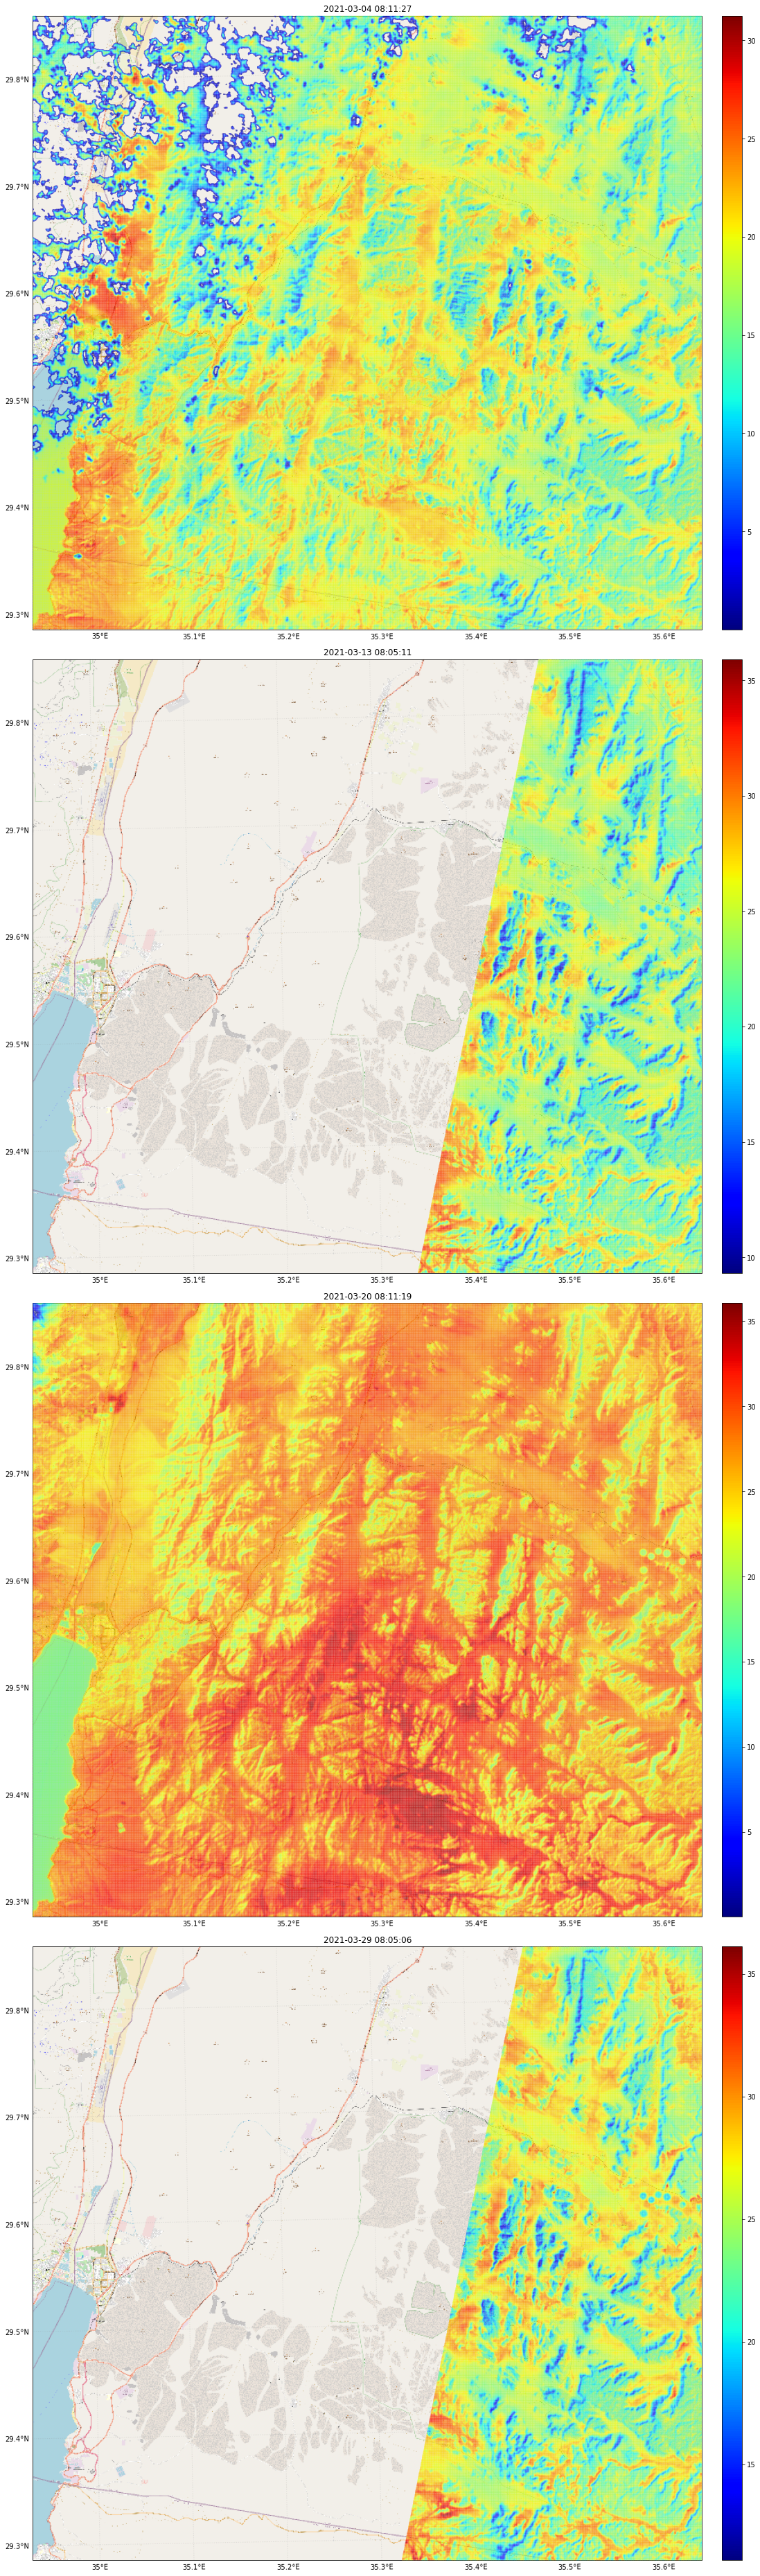

In [16]:
response.plotColorMesh( 'mask-temperature', osm_zoom=13, alpha={ 'data': 0.1, 'grid' : 0.2 } )